# Pix2Pix 

## Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Dropout, Input, concatenate, LeakyReLU, ZeroPadding2D
%matplotlib inline
import matplotlib.pyplot as plt

## Setup GPU

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(f'Available GPUs: {len(gpus)}')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

Available GPUs: 1


## Network Architecture

### Upsampling Block

In [3]:
def upsamp_block(input_layer, skip_layer, index: int, filters: int, kernel_size: tuple, strides: tuple, dropout: bool = False):
    name = 'Conv2D_Trans_Layer'+str(index)
    conv_trans_layer = Conv2DTranspose(filters=filters,kernel_size=kernel_size,
                        padding="same", strides=strides,
                        kernel_initializer=tf.random_normal_initializer(0., 0.02),
                        use_bias=False,
                        name=name)(input_layer)
    layer = concatenate([skip_layer, conv_trans_layer], axis=3)
    layer = BatchNormalization()(layer)
    
    if dropout:
        layer = Dropout(0.35)(layer)
    layer = LeakyReLU(0.2)(layer)
    
    return layer

### Downsampling Block

In [4]:
def downsamp_block(input_layer, index: int, filters: int, kernel_size: tuple, strides: tuple, batch_norm: bool = True):
    name = 'Conv2D_Layer'+str(index)
    layer = Conv2D(filters=filters,kernel_size=kernel_size,
                        padding="same", strides=strides,
                        kernel_initializer=tf.random_normal_initializer(0., 0.02),
                        use_bias=False,
                        name=name)(input_layer)
    if batch_norm:
        layer = BatchNormalization()(layer)
        
    layer = LeakyReLU(0.2)(layer)
    return layer

## Generator Architecture

In [5]:
GEN_INPUT_SHAPE = (256, 256, 3)

### Encoder Architecture

In [6]:
input_layer = Input(GEN_INPUT_SHAPE)
downsamp_layer1 = downsamp_block(input_layer, 1, 64, (4,4), (1,1), batch_norm= False)
downsamp_layer2 = downsamp_block(downsamp_layer1, 2, 128, (4,4), (2,2))
downsamp_layer3 = downsamp_block(downsamp_layer2, 3, 256, (4,4), (2,2))
downsamp_layer4 = downsamp_block(downsamp_layer3, 4, 512, (4,4), (2,2))
downsamp_layer5 = downsamp_block(downsamp_layer4, 5, 512, (4,4), (2,2))
downsamp_layer6 = downsamp_block(downsamp_layer5, 6, 512, (4,4), (2,2))
downsamp_layer7 = downsamp_block(downsamp_layer6, 7, 512, (4,4), (2,2))
downsamp_layer8 = downsamp_block(downsamp_layer7, 8, 512, (4,4), (2,2))

### Decoder Architecture

In [7]:
upsamp_layer1 = upsamp_block(downsamp_layer8, downsamp_layer7, 1, 512, (4,4), (2,2), True)
upsamp_layer2 = upsamp_block(upsamp_layer1, downsamp_layer6, 2, 512, (4,4), (2,2), True)
upsamp_layer3 = upsamp_block(upsamp_layer2, downsamp_layer5, 3, 512, (4,4), (2,2), True)
upsamp_layer4 = upsamp_block(upsamp_layer3, downsamp_layer4, 4, 512, (4,4), (2,2))
upsamp_layer5 = upsamp_block(upsamp_layer4, downsamp_layer3, 5, 256, (4,4), (2,2))
upsamp_layer6 = upsamp_block(upsamp_layer5, downsamp_layer2, 6, 128, (4,4), (2,2))
upsamp_layer7 = upsamp_block(upsamp_layer6, downsamp_layer1, 7, 64, (4,4), (2,2))
output_layer = Conv2D(filters=3,kernel_size=(4,4),
                        padding="same", strides=(1,1),
                        kernel_initializer=tf.random_normal_initializer(0., 0.02),
                        activation='tanh',
                        name='Conv2D_Layer_Final')(upsamp_layer7)

## Generator Model Instantiation

In [8]:
generator = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='Generator')
generator.summary()

Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv2D_Layer1 (Conv2D)         (None, 256, 256, 64  3072        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 256, 256, 64  0           ['Conv2D_Layer1[0][0]']          
                                )                                                         

## Discriminator Architecture

In [9]:
DISC_INPUT_SHAPE = (256, 256, 6)

In [10]:
input_layer = Input(DISC_INPUT_SHAPE)
downsamp_layer1 = downsamp_block(input_layer, 9, 64, (4,4), (2,2), batch_norm= False)
downsamp_layer2 = downsamp_block(downsamp_layer1, 10, 128, (4,4), (2,2))
downsamp_layer3 = downsamp_block(downsamp_layer2, 11, 256, (4,4), (2,2))

zeropad_layer = ZeroPadding2D()(downsamp_layer3)
conv_layer = Conv2D(filters=512, kernel_size=(4,4), strides=(1,1),
                   kernel_initializer=tf.random_normal_initializer(0., 0.02),
                   use_bias=False,
                   name='Conv2D_Layer_D1')(zeropad_layer)

batchnorm_layer = BatchNormalization()(conv_layer)
leaky_relu_layer = LeakyReLU()(batchnorm_layer)

zeropad_layer = ZeroPadding2D()(leaky_relu_layer)
output_layer = Conv2D(filters=1, kernel_size=(4,4), strides=(1,1),
                   kernel_initializer=tf.random_normal_initializer(0., 0.02),
                   name='Conv2D_Layer_D2')(zeropad_layer)

## Discriminator Model Instantiation

In [11]:
discriminator = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='Discriminator')
discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 6)]     0         
                                                                 
 Conv2D_Layer9 (Conv2D)      (None, 128, 128, 64)      6144      
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 128, 128, 64)      0         
                                                                 
 Conv2D_Layer10 (Conv2D)     (None, 64, 64, 128)       131072    
                                                                 
 batch_normalization_14 (Bat  (None, 64, 64, 128)      512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 64, 64, 128)       0         
                                                     

## cGAN Model

In [12]:
from tensorflow.keras.losses import BinaryCrossentropy, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam

In [13]:
def create_gan(gen, disc, gen_optimizer, lambda_mae):
    # Freeze the Discriminator Network
    disc.trainable = False
    
    input_layer= Input(GEN_INPUT_SHAPE)
    gen_output = gen(input_layer)
    disc_input = concatenate([input_layer, gen_output], axis=3, name='ImageFusionLayer')
    disc_output = disc(disc_input)
    adversarial_model = tf.keras.Model(inputs=input_layer,outputs={'bin_out': disc_output, 'pixel_out': gen_output}, name='GAN')
    
    adversarial_model.compile(loss={'bin_out': BinaryCrossentropy(), 'pixel_out': MeanAbsoluteError()},
                              loss_weights={'bin_out': 1, 'pixel_out':lambda_mae},
                             optimizer=gen_optimizer)
    return adversarial_model

## Instantiate cGAN Model

In [14]:
gen_optimizer = Adam(2e-4, beta_1=0.5)
disc_optimizer = Adam(2e-4, beta_1=0.5)

In [15]:
discriminator.compile(loss=BinaryCrossentropy(), optimizer=disc_optimizer)

In [16]:
LAMBDA_MAE = 100
gan = create_gan(generator, discriminator, gen_optimizer, LAMBDA_MAE)
gan.summary()

Model: "GAN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Generator (Functional)         (None, 256, 256, 3)  54435843    ['input_3[0][0]']                
                                                                                                  
 ImageFusionLayer (Concatenate)  (None, 256, 256, 6)  0          ['input_3[0][0]',                
                                                                  'Generator[0][0]']              
                                                                                                

## Load Dataset

In [17]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

In [18]:
DIR = 'facades/train/'
data = []
for image_name in os.listdir(DIR):
    image = img_to_array(load_img(DIR+image_name))
    data.append(image)
NUM_IMAGES = len(data)
print(f'Number of Images Found: {NUM_IMAGES}')
data = np.array(data, dtype=np.float32)

Number of Images Found: 400


In [19]:
BATCH_SIZE = 1

## Visualize Dataset

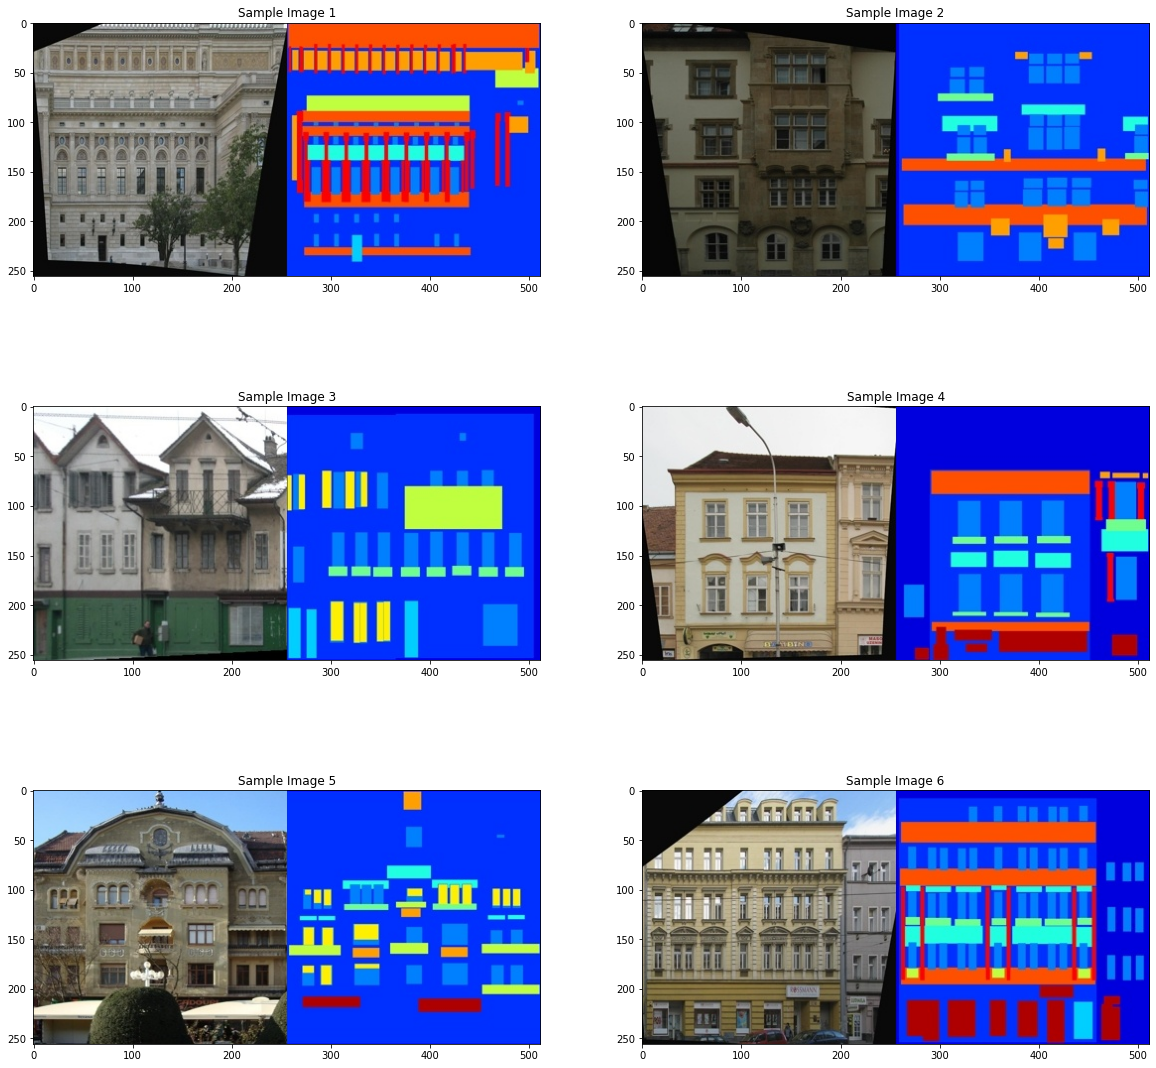

In [20]:
_, ax = plt.subplots(ncols=2, nrows=3, figsize=(20,20))
sample_indices = np.random.choice(NUM_IMAGES, 6)
for i in range(6): 
    image = data[sample_indices[i]]
    ax[int(i/2)][i%2].imshow(tf.cast(image, tf.int32))
    ax[int(i/2)][i%2].title.set_text(f'Sample Image {i+1}')

## Preprocessing Function

Resize each image from 256 x 256 x 3 to 286 x 286 x 3

In [21]:
def resize(labels, facade, height= 286, width= 286):
    labels = tf.image.resize(labels, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    facade = tf.image.resize(facade, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    return labels, facade

Randomly crop the image back to 256 x 256 x 3

In [22]:
def random_crop(labels, facade):
    stacked_image = tf.stack([labels, facade], axis=1)
    cropped_image = tf.image.random_crop(stacked_image,
                                        size=(BATCH_SIZE, 2, 256, 256, 3))
    
    return cropped_image[:,0,:,:], cropped_image[:,1,:,:]

Separate the labels and the real image from the joined image

In [23]:
def separate(image):
    width = tf.shape(image)[2]
    width = int(width/2)
    facade = image[:,:,:width,:]
    labels = image[:,:,width:,:]
    return labels, facade

## Dataset Generator

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_io as tfio

In [25]:
image_generator = ImageDataGenerator()

In [26]:
def dataset_generator(batch_size=BATCH_SIZE):
    for image_batch in image_generator.flow(data, batch_size=batch_size):
        image_batch = tf.cast(image_batch, dtype=tf.float32)
        # Normalize to [0,1]
        image_batch = image_batch / 255.0
        
        # Preprocess Images
        labels, facade = separate(image_batch)
        labels, facade = resize(labels, facade)
        labels, facade = random_crop(labels, facade)
        
        # Random flipping
        if tf.random.uniform(()) > 0.5:
            labels = tf.image.flip_left_right(labels)
            facade = tf.image.flip_left_right(facade)
        
        # Convert to LAB color-space [-1,1]
        labels =  tfio.experimental.color.rgb_to_lab(labels, illuminant='D65', observer='2') / 128
        facade =  tfio.experimental.color.rgb_to_lab(facade, illuminant='D65', observer='2') / 128
        
        yield labels, facade

## Setup Training Loop

In [27]:
from tensorflow.keras.utils import Progbar

In [28]:
NUM_STEPS = int(NUM_IMAGES / BATCH_SIZE)

In [29]:
def train(gan_model, gen, disc, epochs, steps_per_epoch= NUM_STEPS):
    for epoch in range(epochs):
        step = 0
        progbar = Progbar(steps_per_epoch, width=25, stateful_metrics=['Epoch'])
        for labels, facade in dataset_generator():
            step += 1
            # Training the Discriminator
            real_image = tf.concat([labels, facade], axis=3)
            fake_image = tf.concat([labels, gen(labels, training=False)], axis=3)
            
            X = tf.concat([real_image, fake_image], axis=0)
            y_real = tf.ones((real_image.shape[0], 30, 30, 1))
            y_fake = tf.zeros((fake_image.shape[0], 30, 30, 1))
            y = tf.concat([y_real, y_fake], axis=0)
            
            disc_loss = disc.train_on_batch(X, y)
            
            #Training the Generator
            y_bin = tf.ones((labels.shape[0], 30, 30, 1))
            y_pixel = facade
            
            gen_loss = gan_model.train_on_batch(labels, {'bin_out': y_bin, 'pixel_out': y_pixel})
            
            progbar.add(len(labels), values=[
                    ("Epoch", epoch + 1),
                    ("Disc Loss", disc_loss),
                    ("Gen Loss", gen_loss[0]),
                    ("Gen GAN", gen_loss[1]),
                    ("Gen L1", gen_loss[2])
                    ])
            
            if step == steps_per_epoch:
                break

## Train the Model

In [30]:
train(gan, generator, discriminator, 100, 50)

50/50 [=========================] - 28s 568ms/step - Epoch: 100.0000 - Disc Loss: 7.6469 - Gen Loss: 15.5624 - Gen GAN: 8.0861 - Gen L1: 0.0748


## Test the Model

### Load the Test Data

In [31]:
TEST_DIR = 'facades/test/'
test_data_X = []
test_data_y = []
for image_name in os.listdir(TEST_DIR):
    image = img_to_array(load_img(TEST_DIR+image_name))
    image = tf.cast(image, dtype=tf.float32)
    # Normalize to [0,1]
    image = image / 255.0
    labels, facade = image[:,256:,:], image[:,:256,:]
    # Convert to LAB color-space
    labels =  tfio.experimental.color.rgb_to_lab(labels, illuminant='D65', observer='2') / 128
    test_data_X.append(labels)
    test_data_y.append(facade)
    
test_data_X = np.array(test_data_X, dtype=np.float32)
NUM_TEST_IMAGES = len(test_data_X)
print(f'Number of Images Found: {NUM_TEST_IMAGES}')

Number of Images Found: 106


### Predict

In [32]:
pred = generator.predict(test_data_X[:10,:,:,:])

1/1 [==============================] - 6s 6s/step


## Visualize results

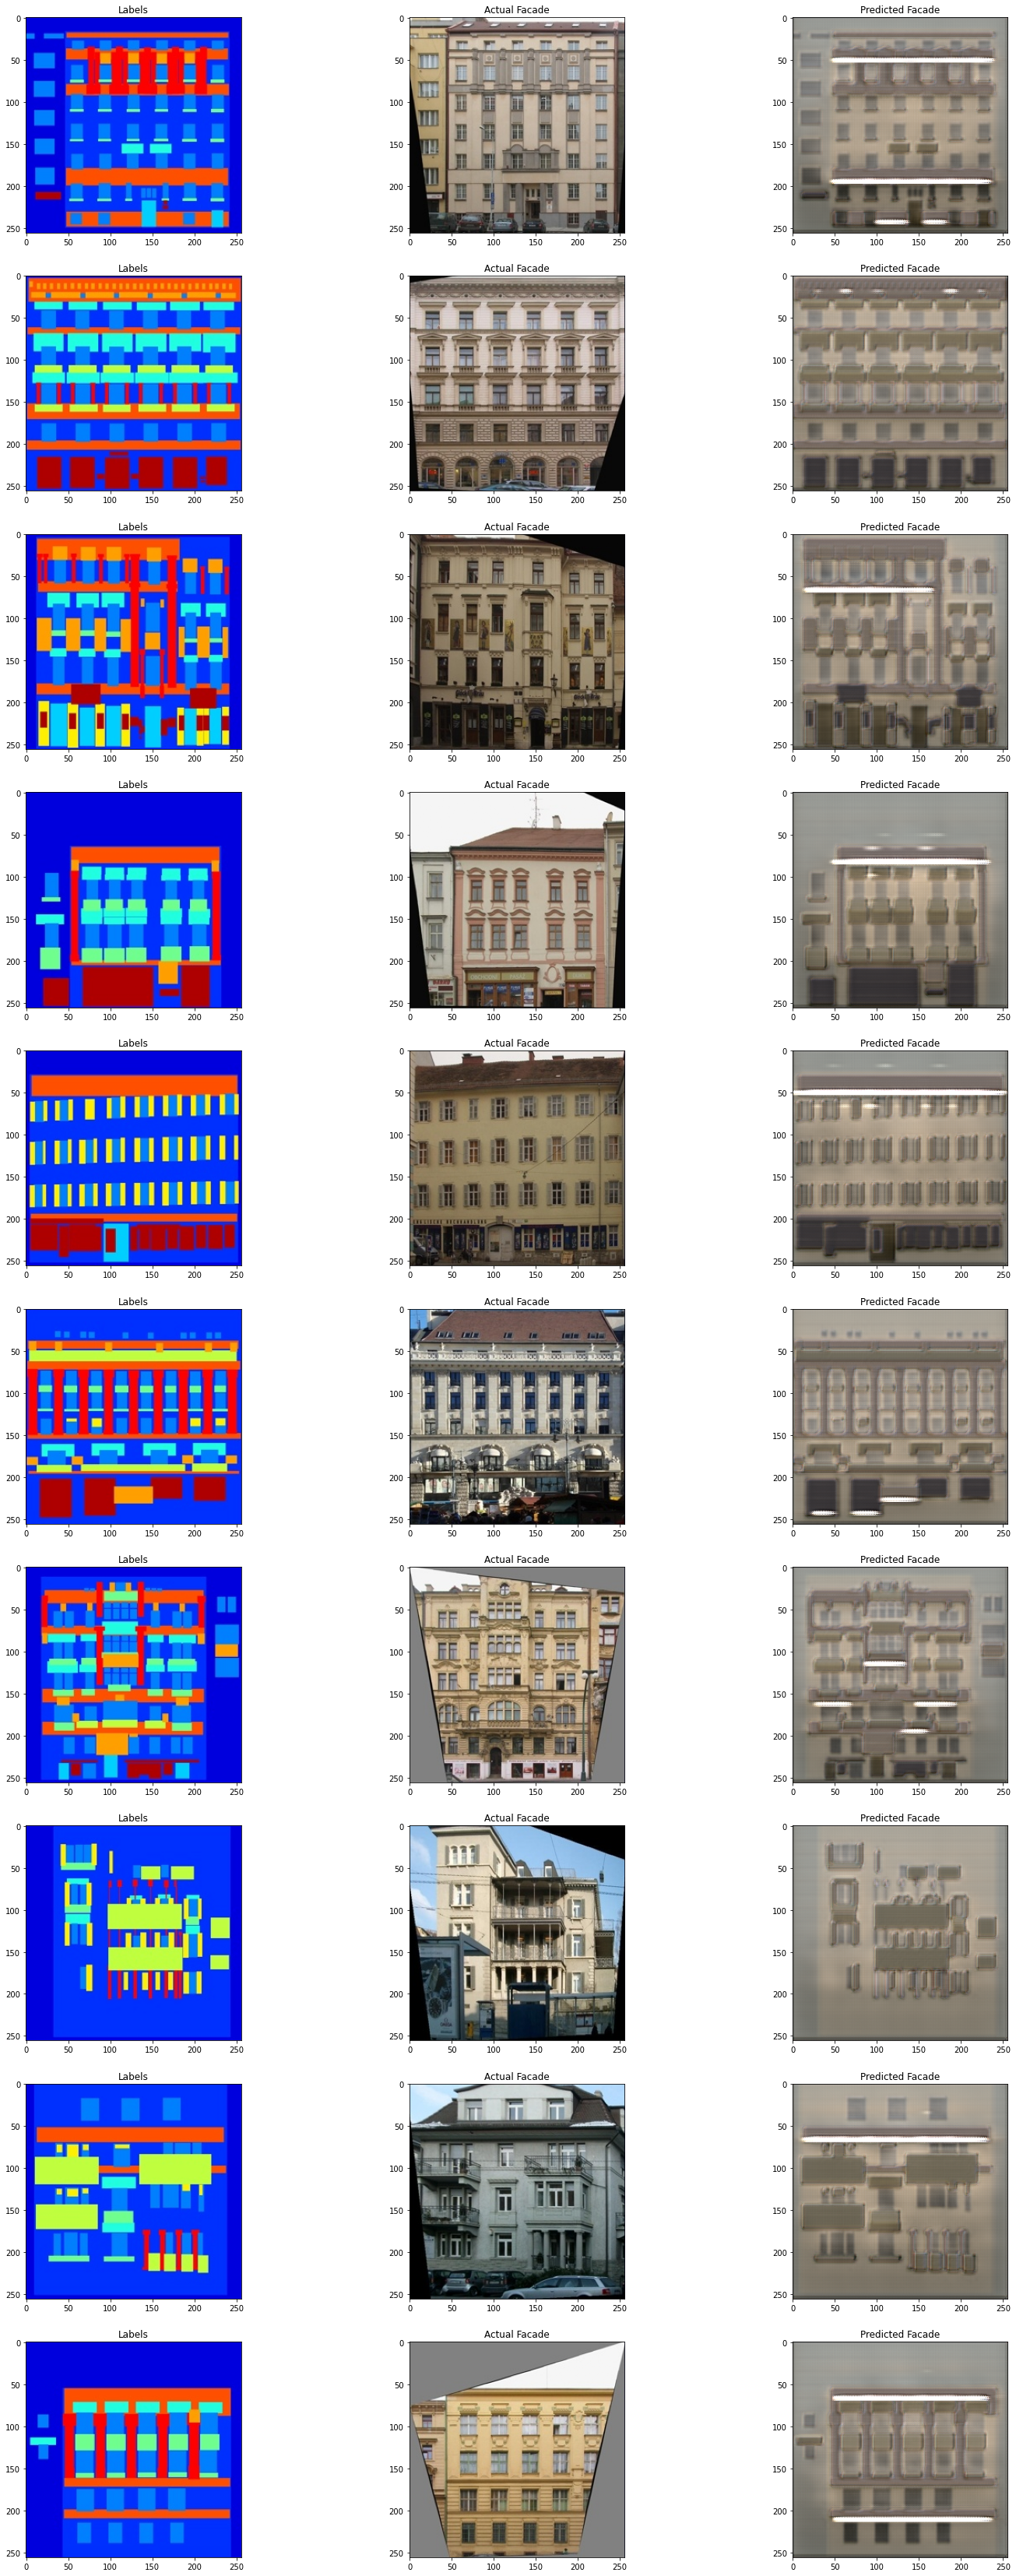

In [33]:
_, ax = plt.subplots(10, 3, figsize=(25,60))
for i in range(10):
    rgb_pred = tfio.experimental.color.lab_to_rgb(pred[i] * 128, illuminant='D65', observer='2')
    labels = tfio.experimental.color.lab_to_rgb(test_data_X[i] * 128, illuminant='D65', observer='2')
    ax[i][0].imshow(labels)
    ax[i][0].title.set_text('Labels')
    ax[i][1].imshow(test_data_y[i])
    ax[i][1].title.set_text('Actual Facade')
    ax[i][2].imshow(rgb_pred)
    ax[i][2].title.set_text('Predicted Facade')

## Save Model Weigths

In [34]:
generator.save_weights('generator_unet.h5')
discriminator.save_weights('discriminator_unet.h5')

## Save Optimizer States

In [35]:
import pickle

In [36]:
def save_opt(model, name):
    symbolic_weights = getattr(model.optimizer, 'weights')
    weight_values = tf.keras.backend.batch_get_value(symbolic_weights)
    with open(name, 'wb') as f:
        pickle.dump(weight_values, f)

In [37]:
save_opt(gan, 'gan_opt.pkl')
save_opt(discriminator, 'disc_opt.pkl')

## Note

1. BATCH_SIZE is recommended to be between 1 and 10
2. The model needs to be trained more for better results (this is for educational purposes only)
3. A better selection of steps_per_epoch and BATCH_SIZE may be made. Since this is for educational purposes and trained on a personal laptop, the steps, epochs, and batch_size are set low.